
# Automated Fault Slip Tendency Map 

## Brendan Elliott
###### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin

_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Jack Xiao, Graduate Student, The University of Texas at Austin
##### [Twitter](https://twitter.com/jackxiao6) | [LinkedIn](https://www.linkedin.com/in/yuchen-jack-xiao-b1b20876/)


### Executive Summary


Fault maps or natural fracture orientation maps are commonly generated by many subsurface teams in the oil/gas Industry, there are significant efforts required to extract use of this data in a seamless/automated method. The major opportunity with this project is to provide a tool that computes parameters from an image or map, and generates new insights to extract additional value from the existing fault images.
This workflow displays a script that can interpret a simple fault map, automatically identify faults, tune the hyperparameters used, and generate a slip tendency prediction. The image detection will utilize Canny, which is an automatic edge detection algorithm and can be thought of as the machine learning element of the project, in addition HoughLines has many optimization parameters which can be leveraged for optimal image recognition. • The data will simply consist of several high contrast fault images that are publicly available, and general input data for stresses.



### Workflow  

Workflow Steps
• Import image/ datafile 
• Standardize image for processing 
• Utilize edge detection algorithm (Canny) and Houghlines 
• Hyperparameter Tuning for Image Optimization
• Draw fault lines on image for stress characterization 
• Run each fault through mohr circle analysis to predict shear stress on fault 
• Color faults by failure tendency 
• Export all plots and figures for interpretation

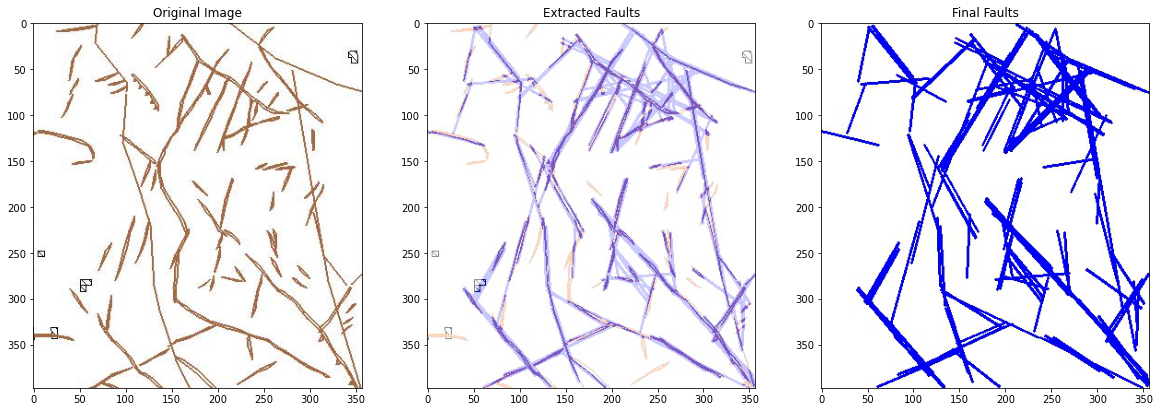

### Import Packages



In [1]:
import cv2                              #to deal with all things images
import skimage                      #Image processing in python
from skimage import data, img_as_float, io
from skimage.measure import compare_ssim
from skimage.metrics import structural_similarity
from skimage.metrics import mean_squared_error
import matplotlib                       # for plotting
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import matplotlib.pylab as pl
import matplotlib.colors as colors
import matplotlib.cm as cmx

import os                               # to set current working directory 
import numpy as np                      # arrays and matrix math
import scipy.stats as st                 # statistical methods
import pandas as pd                     # DataFrames
from IPython.display import Image       #for ease to display figures
from IPython.display import display      #for ease to display figures                 
import math                               #mathamatical operators
from ipywidgets import interact         #for interactive features
import ipywidgets as widgets
import requests                          #To pull the sample image from github


### Functions



In [2]:

#Functions to plot Mohrs Circles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import cos
from math import sin
from math import radians

def mohr_circ_plot(S):
    S1,S2,S3 = np.linalg.eigvalsh(S)
   #find radius and center of each circle 
    R1 = 0.5*(S1-S3)   
    C1 = 0.5*(S1+S3)    
    R2 = 0.5*(S1-S2)
    C2 = 0.5*(S1+S2)
    R3 = 0.5*(S2-S3)
    C3 = 0.5*(S2+S3) 
  
    #create each circle
    circ1 = plt.Circle((C1,0), R1, facecolor='none',alpha=.01, lw=2, edgecolor='k')
    circ2 = plt.Circle((C3,0), R3, facecolor='gray',alpha=.01, lw=1, edgecolor='b')
    circ3 = plt.Circle((C2,0), R2, facecolor='gray',alpha=.01, lw=1, edgecolor= 'b')
    plt.axis('image')    #'scaled' with axis limits equal to data limits.
    ax = plt.gca()
    ax.add_artist(circ1)
    ax.add_artist(circ2)
    ax.add_artist(circ3)
    ax.set_xlim(0, S3-.5*R3) 
    ax.set_ylim(0, -1.5*R1)
    plt.xlabel(r"normal stress",size=14)
    plt.ylabel(r"shear stress",size=14)   
    
def get_new_vec(strike, dip):
    #calculate normal vector of fault plane coord system
    n_n=np.array([-sin(strike)*sin(dip), 
                  cos(strike)*sin(dip),
                  -round(cos(dip),10)])
    n_n=np.matrix.round(n_n, 10)
    n_n[n_n==-0]=0
    #calculate strike vector of fault plane coord system
    n_s=np.array([cos(strike), 
                  sin(strike),
                  0])
    n_s=np.matrix.round(n_s, 10)
    n_s[n_s==-0]=0
    #calculate dip vector of fault plane coord system
    n_d=np.array([-sin(strike)*(round(cos(dip),10)), 
                  cos(strike)*(round(cos(dip),10)),
                  sin(dip)])
    n_d=np.matrix.round(n_d, 10)
    n_d[n_d==-0]=0
    return n_n, n_s, n_d

def get_sigma_tao(S_g,n_n, n_s, n_d,Pp):
    
#projecting the stress tensor based on the geographical coordinate system onto
# the fault base vectors. The stress vector acting on the plane of the fault is 
# {t} (note that {t} is not necessarily aligned with {n}_d, {n}_s or {n}_n)
    
    t=np.dot(S_g,n_n)
    #The total normal stress on the plane of the fault is S_n
    S_n=np.dot(t,n_n)
    #compute shear on fault plane
    tao_d=np.dot(t,n_d)
    tao_s=np.dot(t,n_s)
    #absolute normal stress and absolute shear stress
    sigma_n=np.dot(t,n_n)
    sigma_n=sigma_n-Pp
    tao=np.sqrt(tao_d**2+tao_s**2)
    #shear=tao/sigma_n
    return sigma_n, tao
    
def get_R_pg(alpha, beta, gamma):
    alpha=alpha+radians(90)
    R_pg=np.array([
        [(cos(alpha))*(cos(beta)),(sin(alpha))*(cos(beta)),(-sin(beta))],
    
        [((cos(alpha))*(sin(beta))*(sin(gamma)))-((sin(alpha))*(round(cos(gamma),10))),
         ((sin(alpha))*(sin(beta))*(sin(gamma)))+((cos(alpha))*(round(cos(gamma),10))),
         (cos(beta))*(sin(gamma))],
        
        [((cos(alpha))*(sin(beta))*(cos(gamma)))+((sin(alpha))*(sin(gamma))),
         ((sin(alpha))*(sin(beta))*(cos(gamma)))-((cos(alpha))*(sin(gamma))),
         (cos(beta))*(round(cos(gamma),10))]])
    R_pg[R_pg==-0]=0
    R_pg=np.matrix.round(R_pg, 10)

    #compute Transpose of R_pg
    R_pg_T=R_pg.transpose()
    return R_pg,R_pg_T


def get_tensor(S1, S2, S3):
    S_p = np.array([
    [S1,0,0],
    [0,S2,0],
    [0,0,S3]]) 
    return S_p

def Pp_injection(Pp,X):
    Pp_inj = Pp + X
    return Pp_inj

def get_eff_tensor(S1, S2, S3, Pp):
    sigma = np.array([
    [(S1-Pp),0,0],
    [0,(S2-Pp),0],
    [0,0,(S3-Pp)]]) 
    return sigma

#https://www.pyimagesearch.com/2014/09/15/python-compare-two-images/
def mse(x, y):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((x.astype("float") - y.astype("float")) ** 2)
	err /= float(x.shape[0] * x.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err



### Set Directory and Load the Image File
loading the map of your Faults to be interpreted.  Here it loads a .png file type and displays the image for a visual QC.

Figure should be formatted in the following way:
    North Up orientation
    Clean faults only, high contrast images and white background works best
    Remove the following details for best results (wells, acreage lines, county lines, roads, contours, etc)

    


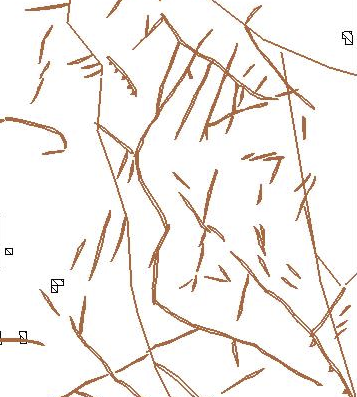

In [3]:
#set directory to be used to read and save files
os.chdir(r"C:\Users\Brendan Elliott\PROGRAMS\SSML_PGE_383\FINAL_PROJECT")    

#select the image to utilize from working directory.(.PNG file format prefered)
#typically the user will have .PNG files on thier computer to use, here i have a sample image hosted in Github

#image= 'test2.png'
#image= 'Permian_Basin_Area3.png'
#image= 'High_Island_Zoom.png'
#image= 'SE_NM_Example_clean.png'
#image= 'Stanford_clean.png'
#image= 'Nio_curvature.png'
#image= 'Nio2.png'
#image= 'Permian_Basin_Area3.png'
#image= 'STACK.png'
#image = 'testimage.jpg'
#image= 'SE_NM_Example_clean_black.png'

response= requests.get("https://github.com/brendan07elliott/PGE383_FinalProject/blob/main/SE_NM_Example_clean.PNG?raw=true")
file = open("image.png", "wb")
file.write(response.content)
file.close
image = 'image.png'
img = cv2.imread(image)

#display the image
#Image(filename = "Stanford_clean.png", width = 300, height = 300)
Image(data = str(image), width = 300, height = 300)

### Edge detection using Canny

Canny is a common edge detection algorithm in OpenCV.  It is a multi-stage process comprised of the following steps:
   
   1) Noise Reduction: 
        (using a gaussian filter to eliminate noise in the image)
   
   2) Finding Intensity Gradient:
        Uses a Sobel Kernel, (discrete differentiation operator), which computes the image intensity function.  It is based on convolving the image with small separable, integer valued filter in horizontal and vertical directions (Gx & Gy).  Then find the edge gradient and direction for each pixel as follows:
   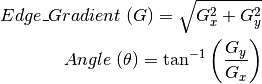  
   
   3) Non-maximum Suppression:
        the algorithm then removes every pixel not associated with an edge(or local maximum) This results in a binary image with identified edges, and works best with high contrast images
 


This section built from OpenCV documentation and partial code edited from Github user Saedeas
(https://stackoverflow.com/questions/45322630/how-to-detect-lines-in-opencv/45560545#45560545)

Text(0.5, 1.0, 'Canny Detected Edges')

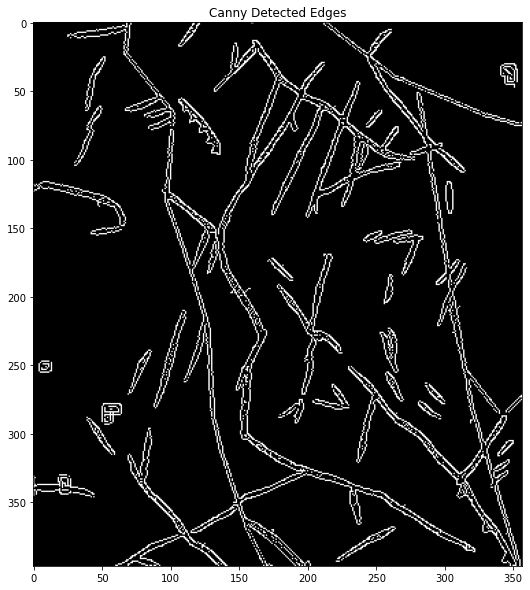

In [4]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
kernel_size = 1
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
plt.figure(figsize = (10,10))
plt.imshow(edges,cmap = 'gray', )
plt.title('Canny Detected Edges')

## Hough Lines Method for Fault Identification and Associated Hyperparameters

lines can be represented as vectors with a magnitude and direction (rho, theta).  HoughlinesP finds line segments in a binary image using the probabilistic Hough transform.  Since we used the Canny method above to generate a binary image of faults, Hough lines will create an array with these parameters for the edge detected image.  The size of this array depends on the accuracy, or threshold values you select.  The identification of a line is accomplished by taking a point and searching around it in the theta (radians) while marking which angle has a point on that line.  The threshold value determines the minimum lenght of the line that should be detected.  The main output from this method is an array of starting and ending points for the faults 
with columns=["x1","y1","x2","y2"]) 

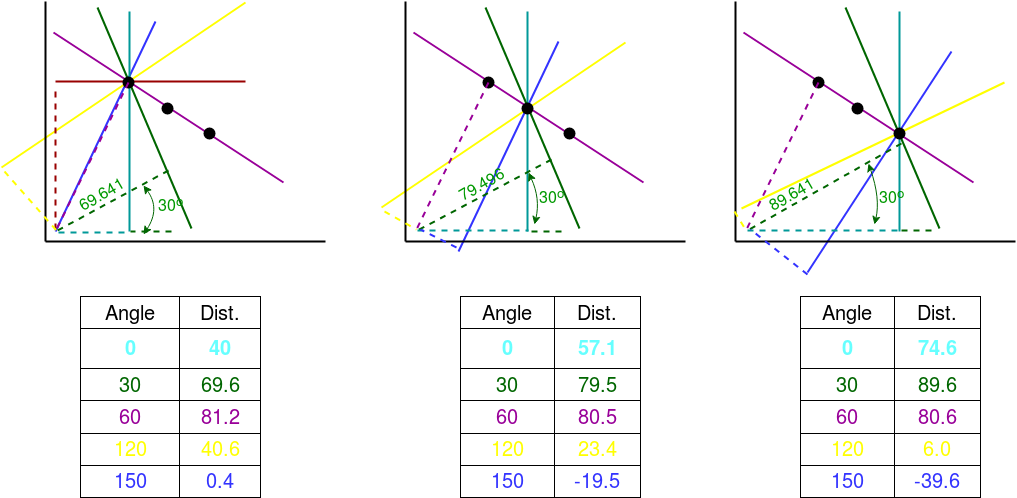
HoughLines example image sourced from: https://www.geeksforgeeks.org/line-detection-python-opencv-houghline-method/

### The Hyperparameters for Hough Lines are: 
#### -rho - Distance resolution in pixels (set to 1 for this exercise)
#### -theta - Angle resolution in radians (set to pi/180 for this exercize)
#### -Threshold - Lines can only be defined if enough points meet this threshold value
#### -Minimum line length - sets the minimum lenght for a line to be defined.  Lower this for higher resolution, more detailed maps
#### -Max line gap - sets the allowable gap for a line to be defined.  lower this to enhance resolution

#### ____

Note:  detail on HoughLine from openCV documentation--> Hough Line Transform

In [5]:
%matplotlib inline
print("\u0332".join("    Interactive Hyperparameters     "))
@interact(kernel_size=(1,10,2),low_threshold=(0,200,1), high_threshold=(100,200,1), threshold=(0,200,1),min_line_length=(5,200,1), max_line_gap=(0,50,1)) # Widget variables 
def plotter(kernel_size=5,low_threshold = 20,high_threshold = 150, threshold=15, min_line_length=50, max_line_gap=20):
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    #kernel = np.ones((5,5), np.uint8)
    #edges = cv2.dilate(edges, kernel, iterations=1)
    
    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    line_image = np.copy(img) * 0 +255 # creating a blank to draw lines on
    
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)
    df=pd.DataFrame(columns=["x1","y1","x2","y2"])   

    for line in lines:
        for x1,y1,x2,y2 in line:
            #print("x1 =", x1,"y1 =", y1,"x2 =", x2,"y2 =", y2)
            df=df.append({"x1":x1,"y1":y1,"x2":x2,"y2":y2},ignore_index=True)
            cv2.line(line_image,(x1,y1),(x2,y2),(250,0,0),2)
           
            #df = pd.DataFrame('data')
            df.to_csv('fault_coords.csv')               
                
    # Draw the lines on the  image
    lines_edges = cv2.addWeighted(img, 0.8, line_image, .5, 0)
    cv2.imwrite('processed.jpg',line_image)
    cv2.imwrite('processed_edges.jpg',lines_edges)
    
    y = Image(filename='processed.jpg', width = 400, height = 400) 
    x = Image(filename=str(image), width = 400, height = 400)   
    
    before = cv2.imread(str(image))
    after = cv2.imread('processed.jpg')

    # Convert images to grayscale
    before_gray = cv2.cvtColor(before, cv2.COLOR_BGR2GRAY)
    after_gray = cv2.cvtColor(after, cv2.COLOR_BGR2GRAY)

    #Compute MSE between images
    mse = mean_squared_error(before, after)
    print("Image MSE", mse, "   <-- MINIMIZE THIS")   
    # Compute SSIM between two images
    #(score, diff) = compare_ssim(before_gray, after_gray, full=True)
    (score, diff) = structural_similarity(before, after, full=True, multichannel=True)
    print("Image Similarity", score, "   <--MAXIMIZE THIS")      
    print(" ")
    print( " Perform an Occular Inspection between images by adjusting hyperparameters")
      
    import matplotlib.image as mpimg
    f, axarr = plt.subplots(1,3, figsize=(20, 30))
    x_ = mpimg.imread(image)
    z_ = mpimg.imread('processed.jpg')
    y_ = mpimg.imread('processed_edges.jpg')
    axarr[0].imshow(x_)
    axarr[0].set_title('Original Image')
    axarr[1].imshow(y_)
    axarr[1].set_title('Extracted Faults')
    axarr[2].imshow(z_)
    axarr[2].set_title('Final Faults')

 ̲ ̲ ̲ ̲I̲n̲t̲e̲r̲a̲c̲t̲i̲v̲e̲ ̲H̲y̲p̲e̲r̲p̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲ ̲ ̲ ̲ 


interactive(children=(IntSlider(value=5, description='kernel_size', max=10, min=1, step=2), IntSlider(value=20…

As can be seen above it is easy with the preset hyperparameters to get a close initial match.  As image quality varies and resolution may change it is important to adjust these hyperparameters accordingly to capture the character of your fault or fracture image.



## Investigating Optimal Hyperparameters via Mean Square Error and Structural Similarity 
This step will tune the above threshold parameter and minimum line length parameter and determine the Mean Square Error (MSE) between the images.  The tuning parameters that minimize the MSE, and Maximize the SS between the images should be selected. This is less important with simple images where an ocular inspection would work, but as complexity increases this helps aid in selection of tuning parameters.

#### Minimum Line Length and Line GapThreshold have the most impact on final image errors, so they are investigated below:


### An important note on using MSE with images is that the calculation is based on distances of pixel intensities, and large resulting values in MSE may not mean the images are drastically different.  Thus the addition of Structural Similary was necessary for this process.  
More information on MSE and SS for image Hyperparameter optimization can be found here.   https://www.pyimagesearch.com/2014/09/15/python-compare-two-images/

#### NOTE THIS CODEBLOCK TAKES A FEW MINUTES TO RUN

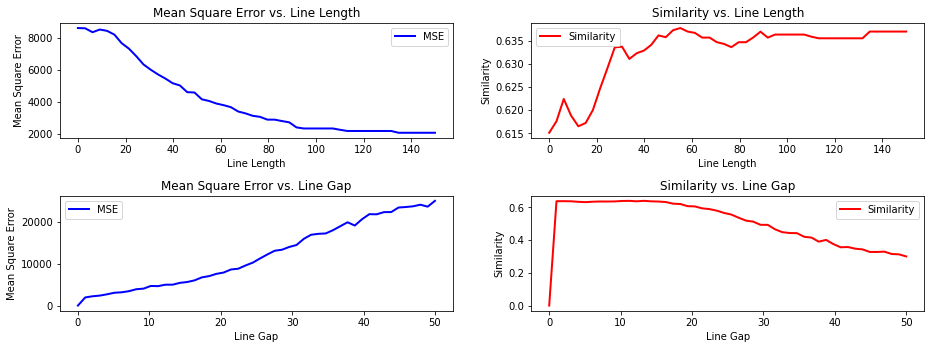

In [9]:

# Arrays to store the results
ncases = 50
lamd_len = np.linspace(0.0,150.0,ncases) #min_line_length=(5,200,1)
#lamd_gap = np.linspace(0.0,50.0,ncases) #max_line_gap=(0,50,1)
lamd_gap = [10]
ss_len = np.zeros(ncases); ss_thresh = np.zeros(ncases)
mse_len = np.zeros(ncases); mse_thresh = np.zeros(ncases)
kernel_size=5 #(1,10,2)
low_threshold=20 #(0,200,1)
high_threshold=150 #(100,200,1)
threshold=15 #(0,200,1)

for i in range(0,len(lamd_len)):                         # Loop over all lambda values
    for j in range(0,len(lamd_gap)):
    
        blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
        edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
        rho = 1  # distance resolution in pixels of the Hough grid
        theta = np.pi / 180  # angular resolution in radians of the Hough grid
        line_image = np.copy(img) * 0+255  # creating a blank to draw lines on

        # Run Hough on edge detected image
        # Output "lines" is an array containing endpoints of detected line segments
        lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                            lamd_len[i], lamd_gap[j])
        df2=pd.DataFrame(columns=["x1","y1","x2","y2"])   

        if lines is None:
            continue
        else:
            for line in lines:
                for x1,y1,x2,y2 in line:
                    #print("x1 =", x1,"y1 =", y1,"x2 =", x2,"y2 =", y2)
                    df2=df2.append({"x1":x1,"y1":y1,"x2":x2,"y2":y2},ignore_index=True)
                    cv2.line(line_image,(x1,y1),(x2,y2),(0,0,0),2)
        
        # Draw the lines on the  image
        lines_edges = cv2.addWeighted(img, 0.5, line_image, 0.5, 0)
        cv2.imwrite('processed.jpg',line_image)

        y = Image(filename='processed.jpg', width = 400, height = 400) 
        x = Image(filename=str(image), width = 400, height = 400)   

        before = cv2.imread(str(image))
        after = cv2.imread('processed.jpg')

        # Convert images to grayscale
        before_gray = cv2.cvtColor(before, cv2.COLOR_BGR2GRAY)
        after_gray = cv2.cvtColor(after, cv2.COLOR_BGR2GRAY)
        #Compute MSE between images
        mse_len[i] = mean_squared_error(before, after)
        #mse_len[i] = mean_squared_error(before_gray, after_gray)

        (score, diff) = structural_similarity(before, after, full=True, multichannel=True)
        ss_len[i] = score

plt.subplot(221)
plt.plot(lamd_len, mse_len,  color='blue', linewidth = 2, label = 'MSE')
#plt.xlim(10.,50.)#; plt.ylim(0,1.0)
plt.title('Mean Square Error vs. Line Length'); plt.xlabel('Line Length'); plt.ylabel('Mean Square Error')
plt.legend()
plt.subplot(222)
plt.plot(lamd_len, ss_len,  color='red', linewidth = 2, label = 'Similarity')
plt.title('Similarity vs. Line Length'); plt.xlabel('Line Length'); plt.ylabel('Similarity')
plt.legend()

ncases = 50
#lamd_len = np.linspace(0.0,150.0,ncases) #min_line_length=(5,200,1)
lamd_gap = np.linspace(0.0,50.0,ncases) #max_line_gap=(0,50,1)
lamd_len = [50]
ss_len = np.zeros(ncases); ss_thresh = np.zeros(ncases)
mse_len = np.zeros(ncases); mse_thresh = np.zeros(ncases)
kernel_size=5 #(1,10,2)
low_threshold=20 #(0,200,1)
high_threshold=150 #(100,200,1)
threshold=15 #(0,200,1)

for i in range(0,len(lamd_len)):                         # Loop over all lambda values
    for j in range(0,len(lamd_gap)):
    
        blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
        edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
        rho = 1  # distance resolution in pixels of the Hough grid
        theta = np.pi / 180  # angular resolution in radians of the Hough grid
        line_image = np.copy(img) * 0+255  # creating a blank to draw lines on

        # Run Hough on edge detected image
        # Output "lines" is an array containing endpoints of detected line segments
        lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                            lamd_len[i], lamd_gap[j])
        df2=pd.DataFrame(columns=["x1","y1","x2","y2"])   

        if lines is None:
            continue
        else:
            for line in lines:
                for x1,y1,x2,y2 in line:
                    #print("x1 =", x1,"y1 =", y1,"x2 =", x2,"y2 =", y2)
                    df2=df2.append({"x1":x1,"y1":y1,"x2":x2,"y2":y2},ignore_index=True)
                    cv2.line(line_image,(x1,y1),(x2,y2),(0,0,0),2)
        
        # Draw the lines on the  image
        lines_edges = cv2.addWeighted(img, 0.5, line_image, 0.5, 0)
        cv2.imwrite('processed.jpg',line_image)

        y = Image(filename='processed.jpg', width = 400, height = 400) 
        x = Image(filename=str(image), width = 400, height = 400)   

        before = cv2.imread(str(image))
        after = cv2.imread('processed.jpg')

        # Convert images to grayscale
        before_gray = cv2.cvtColor(before, cv2.COLOR_BGR2GRAY)
        after_gray = cv2.cvtColor(after, cv2.COLOR_BGR2GRAY)
        #Compute MSE between images
        mse_len[j] = mean_squared_error(before, after)
        #mse_len[j] = mean_squared_error(before_gray, after_gray)

        (score, diff) = structural_similarity(before, after, full=True, multichannel=True)
        ss_len[j] = score

plt.subplot(223)
plt.plot(lamd_gap, mse_len,  color='blue', linewidth = 2, label = 'MSE')
#plt.xlim(10.,50.)#; plt.ylim(0,1.0)
plt.title('Mean Square Error vs. Line Gap'); plt.xlabel('Line Gap'); plt.ylabel('Mean Square Error')
plt.legend()
plt.subplot(224)
plt.plot(lamd_gap, ss_len,  color='red', linewidth = 2, label = 'Similarity')
plt.title('Similarity vs. Line Gap'); plt.xlabel('Line Gap'); plt.ylabel('Similarity')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.5)
plt.legend()

#NOTE THIS BLOCK WILL TAKE A FEW MINUTES TO RUN FOR A LARGE NUMBER OF FAULTS

## Results of Hyperparameter Optimization 
 It is clear that a minimum line length of 50-60 and a line gap threshold below 20 is optimal for this specific fault image.  These hyperparameters are tuned to this image and should be used to rebuild the final dataframe to compute the fault stresses.  This ensures the fault map is as close to the input image as possible.  
 #### From here you should adjust the image in the previous step with the optimized hyperparameters

### INPUT GEOLOGIC/GEOMECHANICAL PARAMETERS
This section will build the basic mohr Columb plots for the identified faults above. Regional stresses, and essential geomechanical properties are user inputs.  Fault dip angle can be normally distributed if there is uncertainty in that parameter.  



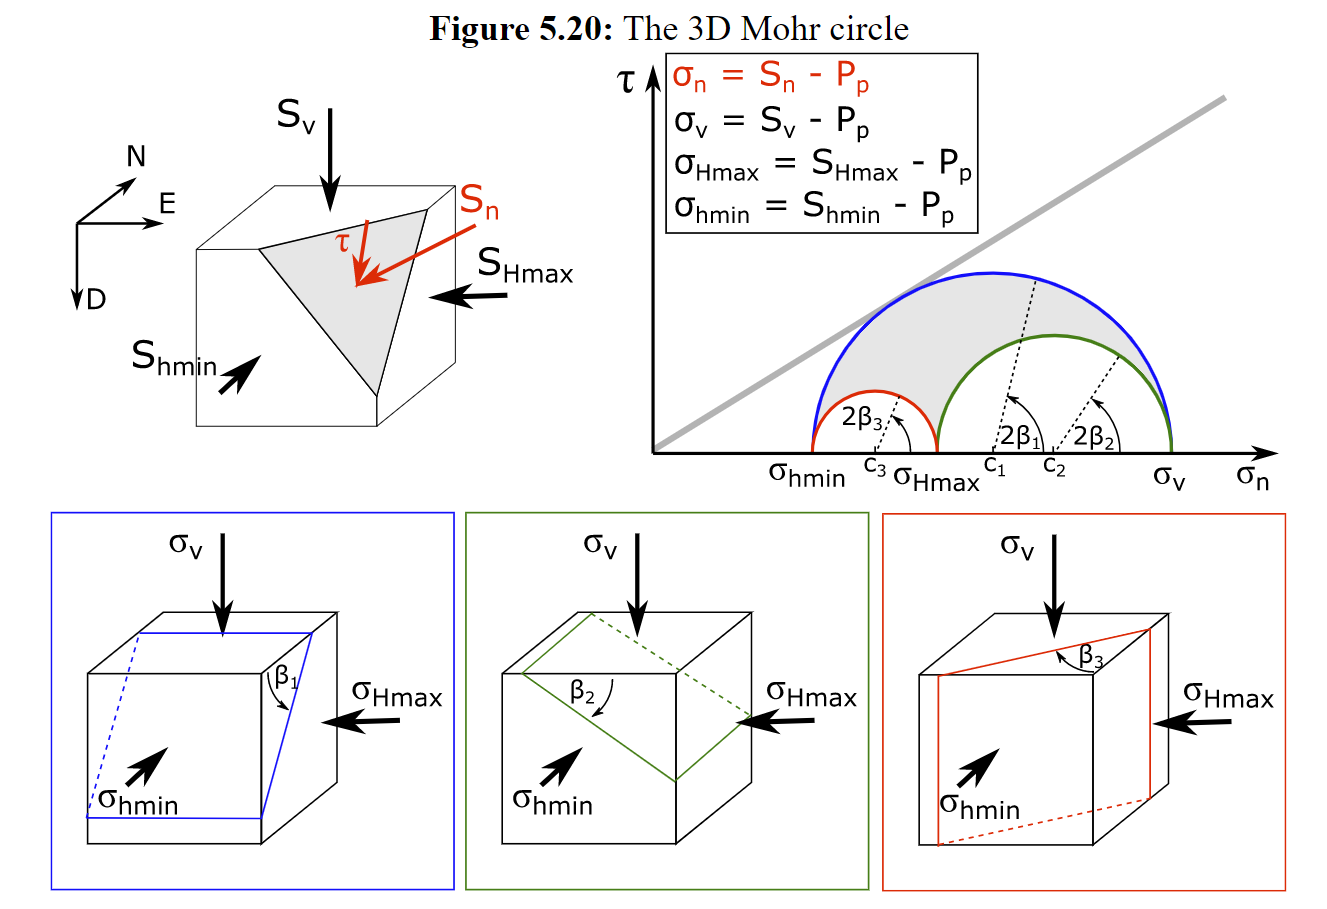

##### Additional Detail for Mohrs Circle can be found here:
https://dnicolasespinoza.github.io/node37.html#SECTION00641000000000000000


In [12]:
#code block that takes x and y positions of faults and determines azimuth (strike) of fault
df=pd.read_csv("fault_coords.csv")
df['slope']=(df.y1-df.y2)/(df.x1-df.x2)
df['Strike']= (90+np.degrees(np.arctan(df.slope)))
df['Sv']=''
df['Sh_min']=''
df['SH_max']=''
df['Pp']=''
df['Dip_deg']=''
df['Average_Depth']=''


#Building the Widgets for User input
Sv = widgets.IntSlider(min=5000,max=10000,step=5, description='Sv:')
Sv.value = 9000
def on_change(v):
    x = v['new']
Sv.observe(on_change,names='value')
display(Sv)

Sh_min = widgets.IntSlider(min=5000,max=10000,step=5, description='Sh_min:')
Sh_min.value = 6000
def on_change2(v2):
    x = v2['new']
Sh_min.observe(on_change2,names='value')
display(Sh_min)

SH_max = widgets.IntSlider(min=5000,max=10000,step=5, description='SH_max:')
SH_max.value = 8000
def on_change2(v2):
    x = v2['new']
SH_max.observe(on_change2,names='value')
display(SH_max)

Pp = widgets.IntSlider(min=3000,max=10000,step=5, description='Pp:')
Pp.value = 5000
def on_change2(v2):
    x = v2['new']
Pp.observe(on_change2,names='value')
display(Pp)

Dip = widgets.IntSlider(min=0,max=90,step=5, description='Dip_deg:')
Dip.value = 60
def on_change2(v2):
    x = v2['new']
Dip.observe(on_change2,names='value')
display(Dip)

Dip_stdev = widgets.IntSlider(min=0,max=10,step=1, description='Dip_stdev:')
Dip_stdev.value = 5
def on_change2(v2):
    x = v2['new']
Dip_stdev.observe(on_change2,names='value')
display(Dip_stdev)

IntSlider(value=9000, description='Sv:', max=10000, min=5000, step=5)

IntSlider(value=6000, description='Sh_min:', max=10000, min=5000, step=5)

IntSlider(value=8000, description='SH_max:', max=10000, min=5000, step=5)

IntSlider(value=5000, description='Pp:', max=10000, min=3000, step=5)

IntSlider(value=60, description='Dip_deg:', max=90, step=5)

IntSlider(value=5, description='Dip_stdev:', max=10)

### Set the dataframe with values from widgets

In [13]:
#Once the proper values in the Widgets are set run this block to buid out the dataframe
df['Sv']= ''
df['Sh_min']= ''
df['SH_max']= ''
df['Pp']= ''
df['Dip_deg'] = ''
#df['Dip_deg']=Dip.value
df['Average_Depth']=''

#print([Sv.value, Sh_min.value, SH_max.value, Pp.value, Dip.value, Dip_stdev.value])
df['Sv']= Sv.value
df['Sh_min']= Sh_min.value
df['SH_max']= SH_max.value
df['Pp']= Pp.value
df['Dip_deg'] = pd.DataFrame(dict(a=np.random.normal(Dip.value, Dip_stdev.value, size=df.shape[0])))
#df['Dip_deg']=Dip.value
df['Average_Depth']=10000

df.to_csv('fault_FINAL_DATA.csv')
print('preview of dataframe:  At this point the data is written to a CSV and the user can edit specific properties') 
print( 'of faults if additional detail is known')
df.head(15)

preview of dataframe:  At this point the data is written to a CSV and the user can edit specific properties
of faults if additional detail is known


,Unnamed: 0,x1,y1,x2,y2,slope,Strike,Sv,Sh_min,SH_max,Pp,Dip_deg,Average_Depth
0,0,179,191,353,385,1.114943,138.110841,9000,6000,8000,5000,65.808550,10000
1,1,131,160,223,6,-1.673913,30.854205,9000,6000,8000,5000,58.110127,10000
2,2,287,82,328,317,5.731707,170.103328,9000,6000,8000,5000,48.982938,10000
3,3,191,290,208,225,-3.823529,14.656751,9000,6000,8000,5000,59.990498,10000
4,4,129,221,134,307,17.200000,176.672596,9000,6000,8000,5000,66.808358,10000
5,5,245,30,351,75,0.424528,113.002597,9000,6000,8000,5000,57.298489,10000
6,6,62,395,130,366,-0.426471,66.903178,9000,6000,8000,5000,59.486775,10000
7,7,55,4,103,66,1.291667,142.253195,9000,6000,8000,5000,53.434294,10000
8,8,159,86,300,53,-0.234043,76.827447,9000,6000,8000,5000,60.328533,10000
9,9,331,304,341,356,5.200000,169.114473,9000,6000,8000,5000,59.260745,10000


### Mohrs Circle Faulting Regime


##### The Mohr Circle method and proper stress calculation requires the user to identify the proper principal stress orientations, and faulting regime.  

##### User sets stress azimuth and faulting regime with the aplha, beta, gamma factors according to the image below:
##### - alpha 
##### - beta
##### - gamma

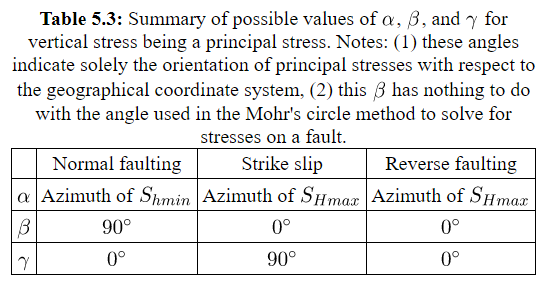



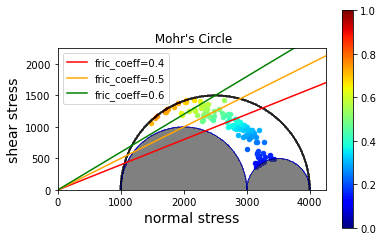

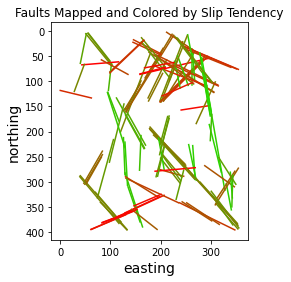

In [14]:
#df = pd.read_csv("Fault_data_ex_2.csv")
#df['slope'] = 

#NOTE:  ALL AZIMUTH MEASUREMENTS ASSUME FROM NORTH = 0 deg to East = 90 deg

#given angles of principal stresses for Normal Faulting
alpha=radians(80)  #angle of Shmax in degrees converted to radians
beta=radians(90)         
gamma=radians(0)

R_pg, R_pg_T = get_R_pg(alpha, beta, gamma)

columns=['sigma_n_norm', 'tao_norm','colorby']
Sigtao_norm=pd.DataFrame(columns=columns)
Sigtao=pd.DataFrame(columns=['sigma_n', 'tao','colorby'])

for index,row in df.iterrows():
    S1=row['Sv']
    S2=row['SH_max']
    S3=row['Sh_min']
    S_p=(get_tensor(S1,S2,S3))  
    Pp=row['Pp']
     
    #Calc new Sg for each fault
    S_g=np.dot(R_pg_T,S_p)
    S_g=np.dot(S_g,R_pg)
    
    n_n, n_s, n_d = get_new_vec(radians(row['Strike']), radians(row['Dip_deg']))
    #input pore pressure gradient
    sigma_n, tao = get_sigma_tao(S_g,n_n, n_s, n_d,Pp)
    
    #colorby=np.divide(sigma_n,tao)
    colorby=(tao/sigma_n)
    Sigtao = Sigtao.append({'sigma_n':sigma_n, 'tao':tao,'colorby':colorby}, ignore_index=True) 
    
    plt.title(" Mohr's Circle") 
    #plot Mohr's circle
    sigma = get_eff_tensor(S1, S2, S3, Pp)
    mohr_circ_plot(sigma)
    #plt.scatter(sigma_n,tao,20, c=colorby,cmap='RdYlGn',vmin=0,vmax=1)
    plt.scatter(sigma_n,tao,20, c=colorby,cmap='jet',vmin=0,vmax=1)

(np.percentile(colorby, 10))

#plot friction assumptions
fric1=.4; fric2=.5; fric3=.6
xs=np.linspace(0,5000,50)
shear_slip1=fric1*xs; shear_slip2=fric2*xs; shear_slip3=fric3*xs
plt.plot(xs,shear_slip1,color='r', label='fric_coeff=0.4')
plt.plot(xs,shear_slip2, color='orange',label='fric_coeff=0.5')
plt.plot(xs,shear_slip3,color='g',label='fric_coeff=0.6')
plt.legend()
plt.colorbar()
plt.show()

###########################################
#Color fault plot:
    
df_colored = pd.concat([df, Sigtao], axis=1, sort=False)

maxcol=np.max(Sigtao['colorby'])
mincol=np.min(Sigtao['colorby'])
#maxcol=np.max(Sigtao['colorby'])
#mincol=np.min(Sigtao['colorby'])

for index,row in df_colored.iterrows():
    plt.plot([row['x1'], row['x2']],[row['y1'], row['y2']],color=(row['colorby']/maxcol, 1-row['colorby']/maxcol, 0))

plt.title("Faults Mapped and Colored by Slip Tendency") 
plt.xlabel(r"easting",size=14)
plt.ylabel(r"northing",size=14)
plt.xlim
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### Calculate and color only faults that are in Failure

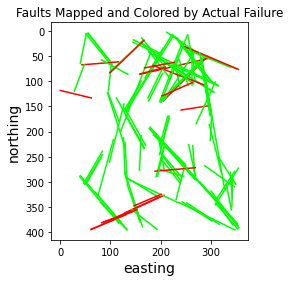

In [15]:
#Color fault plot:
    
#df_colored = pd.concat([df, Sigtao_norm], axis=1, sort=False)
df_colored['fail'] = ''
df_colored.fail = np.where(df_colored.tao/df_colored.sigma_n>=fric3,1,0)
df_colored.head()

maxcol=np.max(Sigtao['colorby'])
mincol=np.min(Sigtao['colorby'])

for index,row in df_colored.iterrows():
    #plt.plot([row['x1'], row['x2']],[row['y1'], row['y2']],color=(1-row['fail'],row['fail'] , 0))
    plt.plot([row['x1'], row['x2']],[row['y1'], row['y2']],color=(row['fail'], 1-row['fail'], 0))
plt.title("Faults Mapped and Colored by Actual Failure") 
plt.xlabel(r"easting",size=14)
plt.ylabel(r"northing",size=14)
plt.xlim
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Thank you for visiting, if you have any futher questions, please do not hesitate to reach out to me at Brendan.elliott@utexas.edu.  

I hope this was helpful,

Brendan Elliott

___________________

#### Work Supervised by:

##### Michael Pyrcz, Associate Professor, University of Texas at Austin 
